In [42]:

# Imports - run this first cell
import os, glob, warnings, json
warnings.filterwarnings('ignore')

import os, glob, warnings, json # Added imports here
import pandas as pd # Added pandas import
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print('Imports done.')


Imports done.


In [43]:
# Data loading - automatic behaviours:
# 1) If the variable `data` already exists in the kernel, we use it.
# 2) Else, if DATA_PATH is set to a valid file, use it.
# 3) Else, try to auto-detect a CSV in the working directory (prefers filenames with 'AQI' or the first CSV found).

import os, glob, warnings, json # Added imports here

DATA_PATH = None  # <-- if you want to force a file, put '/path/to/your.csv' here

def find_csv():
    # prefer files containing 'AQI' or 'aqi' in filename, else pick first csv
    files = glob.glob('AQI-and-Lat-Long-of-Countries.csv')
    if not files:
        return None
    for f in files:
        if 'AQI' in f.upper() or 'aqi' in f.lower():
            return f
    return files[0]

# Use existing 'data' if already loaded interactively
try:
    data  # noqa
    print('Using existing `data` variable from the kernel.')
except NameError:
    if DATA_PATH and os.path.exists(DATA_PATH):
        path = DATA_PATH
    else:
        path = find_csv()
    if path is None:
        raise FileNotFoundError('No CSV found in the notebook folder. Please upload your dataset or set DATA_PATH.')
    print('Loading data from:', path)
    data = pd.read_csv(path)

print('Data shape:', data.shape)
display(data.head(3))

Using existing `data` variable from the kernel.
Data shape: (16695, 7)


,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng
0,51,1,36,0,51,44.7444,44.2031
1,41,1,5,1,41,-5.2900,-44.4900
2,41,1,5,1,41,-11.2958,-41.9869



Columns:
['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value', 'lat', 'lng']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16695 entries, 0 to 16694
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AQI Value        16695 non-null  int64  
 1   CO AQI Value     16695 non-null  int64  
 2   Ozone AQI Value  16695 non-null  int64  
 3   NO2 AQI Value    16695 non-null  int64  
 4   PM2.5 AQI Value  16695 non-null  int64  
 5   lat              16695 non-null  float64
 6   lng              16695 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 913.1 KB


None


Missing values per column:


,0
AQI Value,0
CO AQI Value,0
Ozone AQI Value,0
NO2 AQI Value,0
PM2.5 AQI Value,0
lat,0
lng,0



Numeric columns: ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value', 'lat', 'lng']

Basic description of numeric features:


,count,mean,std,min,25%,50%,75%,max
AQI Value,16695.0,62.998682,43.091971,7.0000,38.50000,52.0000,69.0000,500.0000
CO AQI Value,16695.0,1.342138,2.371379,0.0000,1.00000,1.0000,1.0000,133.0000
Ozone AQI Value,16695.0,31.767355,22.839343,0.0000,20.00000,29.0000,38.0000,222.0000
NO2 AQI Value,16695.0,3.819647,5.880677,0.0000,0.00000,2.0000,5.0000,91.0000
PM2.5 AQI Value,16695.0,59.821324,43.208298,0.0000,34.00000,52.0000,69.0000,500.0000
lat,16695.0,30.267148,22.947398,-54.8019,16.51545,38.8158,46.6833,70.7670
lng,16695.0,-3.944485,73.037148,-171.7500,-75.18000,5.6431,36.2750,178.0178


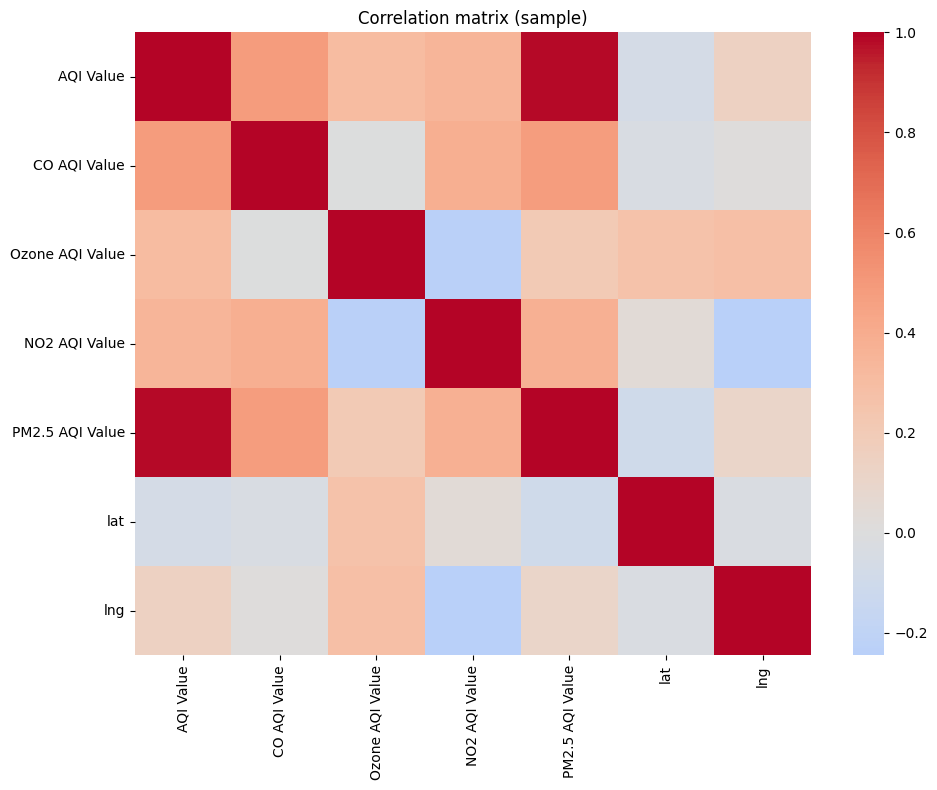

In [44]:

# Quick EDA - run to inspect the dataset
print('\nColumns:')
print(data.columns.tolist())

print('\nData info:')
display(data.info())

print('\nMissing values per column:')
display(data.isnull().sum().sort_values(ascending=False).head(20))

numeric = data.select_dtypes(include=[np.number])
print('\nNumeric columns:', numeric.columns.tolist())

print('\nBasic description of numeric features:')
display(numeric.describe().T)

# Correlation heatmap (sample if too big)
sample_for_corr = numeric.sample(min(len(numeric), 2000), random_state=42)
plt.figure(figsize=(10,8))
sns.heatmap(sample_for_corr.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation matrix (sample)')
plt.tight_layout()


In [45]:

# Preprocessing and target selection heuristics
# Heuristic to pick target column:
preferred_targets = ['co aqi value','ozone aqi value','pm2_5','pm10','aqi','AQI','aqi value','overall_aqi','aqi_value']

cols_lower = [c.lower().strip() for c in data.columns]
col_map = dict(zip(cols_lower, data.columns))  # map lowercase to original

target_col = None
for t in preferred_targets:
    if t in col_map:
        target_col = col_map[t]
        break

if target_col is None:
    # If there is a column containing 'aqi' anywhere in its name, pick it:
    for lc, orig in col_map.items():
        if 'aqi' in lc:
            target_col = orig
            break

if target_col is None:
    # fallback: choose the last numeric column
    numeric_cols = numeric.columns.tolist()
    if numeric_cols:
        target_col = numeric_cols[-1]
    else:
        raise ValueError('Could not automatically determine a target column. Please set target_col manually.')

print('Selected target column:', target_col)

# Basic cleaning: strip column names, drop exact all-NA rows
data.columns = [c.strip() for c in data.columns]
data = data.dropna(how='all').copy()

# Keep numeric features only (you can extend to categorical encoding if needed)
X = data.select_dtypes(include=[np.number]).copy()
if target_col not in X.columns:
    # If selected target wasn't numeric (rare), try to coerce
    X[target_col] = pd.to_numeric(data[target_col], errors='coerce')

# Drop rows where target is NaN
y = X[target_col].copy()
X = X.drop(columns=[target_col])

# Drop columns with zero variance or all NaN
X = X.loc[:, X.nunique() > 1].dropna(axis=1, how='all')

print('Features shape:', X.shape, 'Target shape:', y.shape)
display(X.columns[:20])


Selected target column: CO AQI Value
Features shape: (16695, 6) Target shape: (16695,)


Index(['AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value',
       'lat', 'lng'],
      dtype='object')

In [46]:

# Train / test split
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (13356, 6) Test: (3339, 6)


In [47]:
# Utility function to train a model and compute standard regression metrics.
def evaluate_model(name, model, X_train, y_train, X_test, y_test, do_cv=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    result = {'model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    if do_cv:
        try:
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
            result['CV_R2_mean'] = scores.mean()
            result['CV_R2_std'] = scores.std()
        except Exception as e:
            result['CV_error'] = str(e)
    return result, model, y_pred

# We'll collect results here
results = []
trained_models = {}

In [48]:
# Define models (SVR in a pipeline with scaling)
models_to_run = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'SVR_RBF': Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))])
}

for name, mdl in models_to_run.items():
    print('\nTraining', name)
    res, fitted, y_pred = evaluate_model(name, mdl, X_train, y_train, X_test, y_test, do_cv=True)
    results.append(res)
    trained_models[name] = fitted

results_df = pd.DataFrame(results).set_index('model').round(4)
print('\nEvaluation table (test set):')
display(results_df)


Training LinearRegression


TypeError: got an unexpected keyword argument 'squared'

In [ ]:

# If any CVs failed above, run a lightweight CV summary here (on training data)
cv_summary = []
for name, mdl in models_to_run.items():
    try:
        scores = cross_val_score(mdl, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
        cv_summary.append({'model': name, 'cv_r2_mean': scores.mean(), 'cv_r2_std': scores.std()})
    except Exception as e:
        cv_summary.append({'model': name, 'cv_r2_mean': None, 'cv_r2_std': None, 'error': str(e)})
cv_df = pd.DataFrame(cv_summary).set_index('model').round(4)
print('Cross-validation summary (training data):')
display(cv_df)


In [ ]:
# Choose best model by test R2 and save
results_df_sorted = results_df.sort_values('R2', ascending=False)
best_model_name = results_df_sorted.index[0]
print('Best model on test set:', best_model_name)
best_model_obj = trained_models[best_model_name]

save_path = '/mnt/data/best_model_joblib.joblib'
joblib.dump(best_model_obj, save_path)
print('Saved best model to:', save_path)

# Save results table too
results_df.to_csv('/mnt/data/model_results.csv')
print('Saved evaluation table to /mnt/data/model_results.csv')

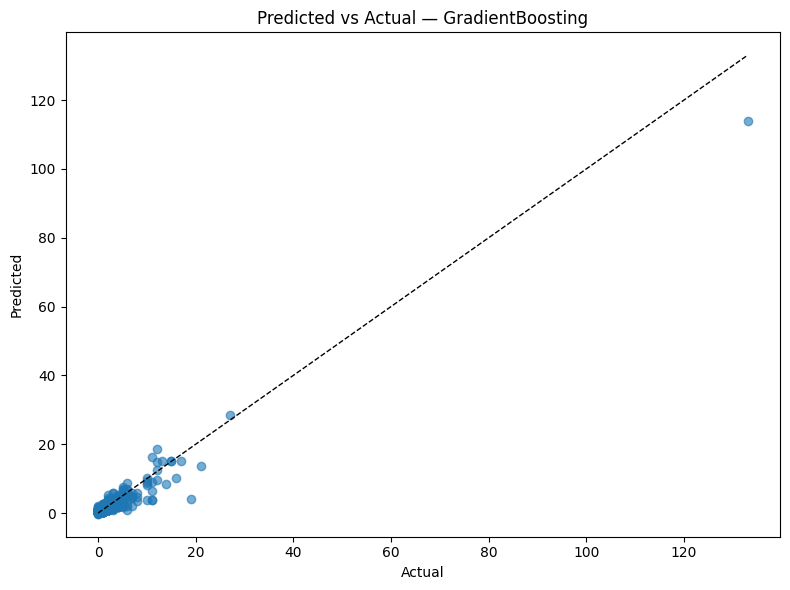

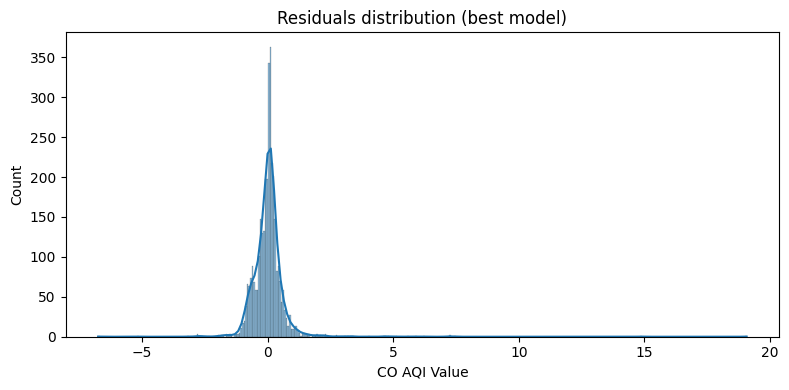

In [49]:

# Plots for the best model's predictions
best = best_model_obj
y_pred_best = best.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Predicted vs Actual — {best_model_name}')
plt.tight_layout()

# Residuals
residuals = y_test - y_pred_best
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title('Residuals distribution (best model)')
plt.tight_layout()


In [50]:

# Feature importance for tree-based models (if available)
for name in ['ExtraTrees','RandomForest','GradientBoosting']:
    if name in trained_models:
        mdl = trained_models[name]
        if hasattr(mdl, 'feature_importances_'):
            fi = pd.Series(mdl.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            print('\nTop 10 feature importances for', name)
            display(fi.head(10))
            plt.figure(figsize=(8,4))
            fi.head(10).plot(kind='bar')
            plt.title(f'{name} - Top 10 feature importances')
            plt.tight_layout()

# Permutation importance for SVR (if present)
if 'SVR_RBF' in trained_models:
    try:
        print('\nPermutation importance (SVR)')
        perm = permutation_importance(trained_models['SVR_RBF'], X_test, y_test, n_repeats=15, random_state=42, n_jobs=-1)
        perm_ser = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
        display(perm_ser.head(10))
        plt.figure(figsize=(8,4))
        perm_ser.head(10).plot(kind='bar')
        plt.title('SVR - Top 10 permutation importances')
        plt.tight_layout()
    except Exception as e:
        print('Permutation importance failed:', e)


In [51]:
# Utility function to train a model and compute standard regression metrics.
def evaluate_model(name, model, X_train, y_train, X_test, y_test, do_cv=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    # FIX: Re-added squared=False to correctly calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    result = {'model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    if do_cv:
        try:
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
            result['CV_R2_mean'] = scores.mean()
            result['CV_R2_std'] = scores.std()
        except Exception as e:
            result['CV_error'] = str(e)
    return result, model, y_pred

# We'll collect results here
results = []
trained_models = {}

In [52]:
# Choose best model by test R2 and save
results_df_sorted = results_df.sort_values('R2', ascending=False)
best_model_name = results_df_sorted.index[0]
print('Best model on test set:', best_model_name)
best_model_obj = trained_models[best_model_name]

# FIX: Save to the current working directory instead of /mnt/data
save_path = 'best_model_joblib.joblib'
joblib.dump(best_model_obj, save_path)
print('Saved best model to:', save_path)

# FIX: Save results table too to the current working directory
results_df.to_csv('model_results.csv')
print('Saved evaluation table to model_results.csv')

Best model on test set: GradientBoosting


KeyError: 'GradientBoosting'

In [ ]:
# Utility function to train a model and compute standard regression metrics.
def evaluate_model(name, model, X_train, y_train, X_test, y_test, do_cv=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) # Removed squared=False
    r2 = r2_score(y_test, y_pred)
    result = {'model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    if do_cv:
        try:
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
            result['CV_R2_mean'] = scores.mean()
            result['CV_R2_std'] = scores.std()
        except Exception as e:
            result['CV_error'] = str(e)
    return result, model, y_pred

# Define models (SVR in a pipeline with scaling)
models_to_run = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'SVR_RBF': Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))])
}

# We'll collect results here
results = []
trained_models = {}

for name, mdl in models_to_run.items():
    print('\nTraining', name)
    res, fitted, y_pred = evaluate_model(name, mdl, X_train, y_train, X_test, y_test, do_cv=True)
    results.append(res)
    trained_models[name] = fitted

results_df = pd.DataFrame(results).set_index('model').round(4)
print('\nEvaluation table (test set):')
display(results_df)